# Packages needed

In [2]:
# Data procesing, description and ploting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne as to
from scipy.stats import hypergeom

# Data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature selection 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Load  data from radiomic and clinical variables Excel files

In [3]:
## Clinical data
# Load clinical data from Excel file
df_clinical = pd.read_excel('E:\TFM Marta\Base de dades\RadioponPulmon_SBRT_TFM v8.xlsx')
# Rename columns for better understanding 
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)
# Convert 'ID' column to float type for consistency in merging
df_clinical['ID'] = df_clinical['ID'].astype(float)
# Print the shape 
print(f"Clinical dataframe shape: {df_clinical.shape}")

## Radiomic data
# Load radiomic data from Excel file
df_radiomic = pd.read_excel('E:\TFM Marta\Codis\Radiomics_Marta.xlsx')
# Clean up 'case_id' by removing the '_MCC' suffix, if present
df_radiomic['case_id'] = df_radiomic['case_id'].str.replace('_MCC$', '', regex=True)
# Rename 'case_id' column to 'ID' to match clinical data
df_radiomic.rename(columns={"case_id": "ID" }, inplace=True)
# Convert 'ID' column to float type for consistency in merging
df_radiomic['ID'] = df_radiomic['ID'].astype(float)
# Print the shape
print(f"Radiomic dataframe shape: {df_radiomic.shape}")

# Merging dataframes and filtering ID present in both
df_common = pd.merge(df_clinical[['ID']], df_radiomic[['ID']], on='ID', how='inner') 

# Filter clinical and radiomic dataframes to only include the common ID
df_clinical = df_clinical[df_clinical['ID'].isin(df_common['ID'])]
df_radiomic = df_radiomic[df_radiomic['ID'].isin(df_common['ID'])]

# Reset indices to ensure the dataframes are well-aligned
df_clinical.reset_index(drop=True, inplace=True)
df_radiomic.reset_index(drop=True, inplace=True)

# Print reshaped datasets
print(f"Common ID dataframe shape: {df_common.shape}")
print(f"Clinical dataframe reshaped: {df_clinical.shape}")
print(f"Radiomic dataframe reshaped: {df_radiomic.shape}")

Clinical dataframe shape: (148, 23)
Radiomic dataframe shape: (153, 1690)
Common ID dataframe shape: (141, 1)
Clinical dataframe reshaped: (141, 23)
Radiomic dataframe reshaped: (141, 1690)


# Clinical data preprocessing (before data splitting)

Index(['Fecha nacimiento', 'FECHA INICIO RT', 'FECHA FINAL RT'], dtype='object')


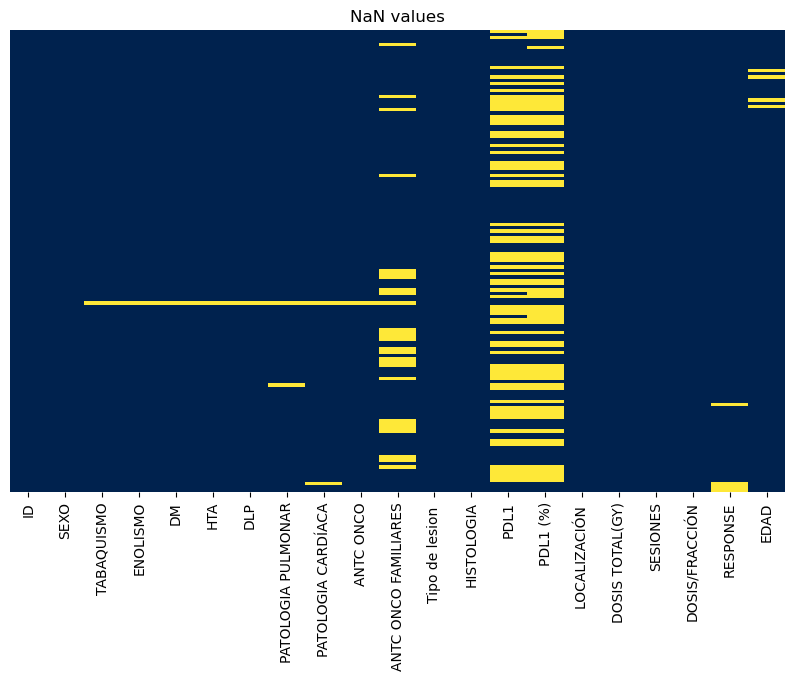

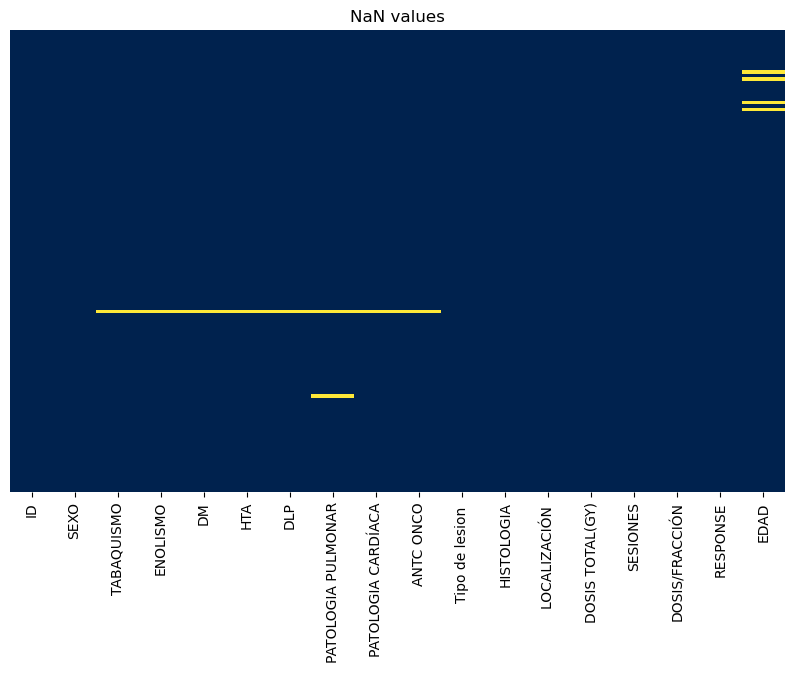

clinical filtered  (137, 18)


In [4]:
## Rename columns
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)

## Age calculation
df_clinical['EDAD'] = (df_clinical['FECHA INICIO RT'] - df_clinical['Fecha nacimiento']).dt.days // 365

## Date variables elimination 
date_columns = df_clinical.select_dtypes(include=['datetime']).columns
print(date_columns)
df_clinical.drop(columns=date_columns, inplace=True)

## "No consta" relabeling to NA 
df_clinical.replace('No consta', np.nan, inplace=True)

## NAs count 
plt.figure(figsize=(10, 6))
sns.heatmap(df_clinical.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_clinical.isna().sum().sum() > 0:
    #Since we want to predict response, drop registies without response value
    df_clinical_filtred = df_clinical.dropna(subset=['RESPONSE'], inplace=True) 

    #Filter columns with more than a 10% of missing values
    nan_percentage = (df_clinical.isna().sum() / len(df_clinical)) * 100
    df_clinical_filtred = df_clinical.loc[:, nan_percentage < 10]

    #Plot the result
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_clinical_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()

else:
    df_clinical_filtred = df_clinical
    print("No NA values in the DataFrame.")

print("clinical filtered ", df_clinical_filtred.shape)

# Clinical data description

In [ ]:
# Remove the 'ID' column from the filtered clinical dataframe to focus on the rest of the variables
df_clinical_data = df_clinical_filtred.drop(columns="ID")

# Numeric variables
numeric_variables = df_clinical_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

# Categroical variables
categoric_variables = df_clinical_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()

# Dosage and sessions as categorical data for analysis
describe_categoric = categoric_variables + ["DOSIS TOTAL(GY)", "SESIONES", "DOSIS/FRACCIÓN"]
describe_numeric = list(set(numeric_variables) - set(["DOSIS TOTAL(GY)", "SESIONES", "DOSIS/FRACCIÓN"]))

# Update the lists to include all categorical and numeric variables
describe_categoric = categoric_variables 

# Create a binary version of the 'RESPONSE' variable for analysis
df_clinical_data["RESPONSE_bin"] = df_clinical_data["RESPONSE"].replace(
    {"Completa": 1, "Parcial ": 1, "Estable": 0, "Progresión": 0}).astype(int)

# Perform the comparative analysis, grouped by the 'RESPONSE_bin' variable
comparative_table = to(df_clinical_data, categorical=describe_categoric, pval=True, groupby="RESPONSE_bin" ,nonnormal=describe_numeric)
print(comparative_table.tabulate(tablefmt = "fancy_grid"))

# comparative_table.to_excel('descriptive_comparative_clinical.xlsx')

# Data splitting

In [ ]:
#Response variable to binary
df_clinical_filtred.loc[:, "RESPONSE"] = df_clinical_filtred["RESPONSE"].replace(
    {"Completa": 1, "Parcial ": 1, "Estable": 0, "Progresión": 0}
).astype(int)

#Predictive variables
X = df_clinical_filtred.drop('RESPONSE', axis=1)

#Predicted variable
y = df_clinical_filtred['RESPONSE']  

## Training (80%) and testing (20%) splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024, stratify=y)

## Output dimensions
print(f'Training dataset: {X_train.shape}')
print(f'Testing dataset: {X_test.shape}') 

# Clinical data preprocessing (after data splitting) 
## Data imputation

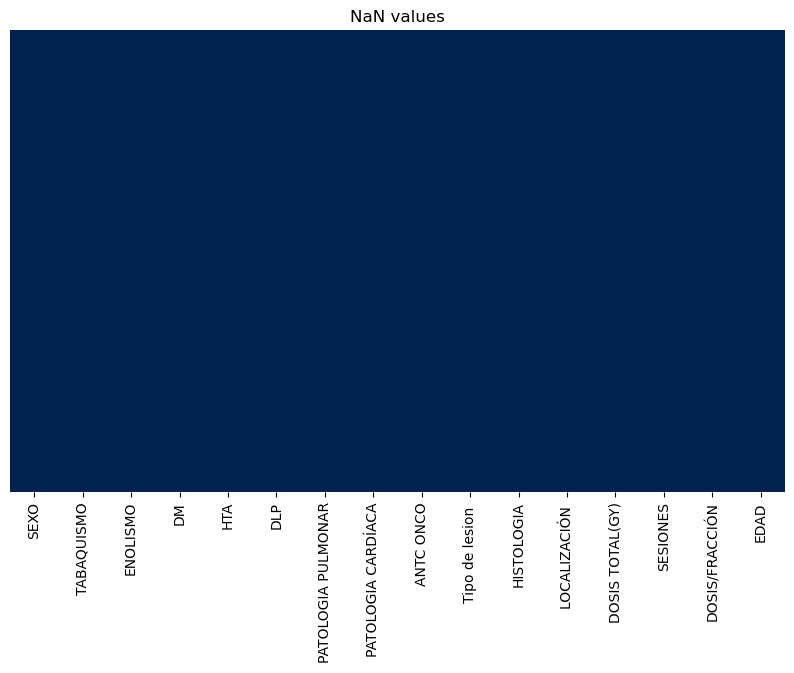

In [45]:
# Remove the 'ID' column from training and testing datasets to focus on the features
X_train_data = X_train.drop(columns="ID")
X_test_data = X_test.drop(columns="ID")

## Numeric data imputation 
# Identify numeric variable
numeric_variables = X_train_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

# Initialize the KNNImputer using 3 nearest neighbors
num_imp= KNNImputer(n_neighbors=3)

# Apply KNN imputation to the numeric variables in the training and testing datasets
X_train_data[numeric_variables] = num_imp.fit_transform(X_train_data[numeric_variables])
X_test_data[numeric_variables] = num_imp.transform(X_test_data[numeric_variables])

## Categoric data imputation 
# Identify categorical variables
categoric_variables = X_train_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()

# SimpleImputer with the most frequent value
cat_imp= SimpleImputer(strategy='most_frequent') 

# Apply imputation for categorical variables in the training and testing datasets
X_train_data[categoric_variables] = cat_imp.fit_transform( X_train_data[categoric_variables])
X_test_data[categoric_variables] = cat_imp.transform(X_test_data[categoric_variables])

### Plot after data imputation
plt.figure(figsize=(10, 6))
sns.heatmap(X_train_data.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Data one-hot encoding

In [46]:
## One-hot encoding 
X_train_encoded = pd.get_dummies(X_train_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Radiomic data preprocessing (before data splitting)

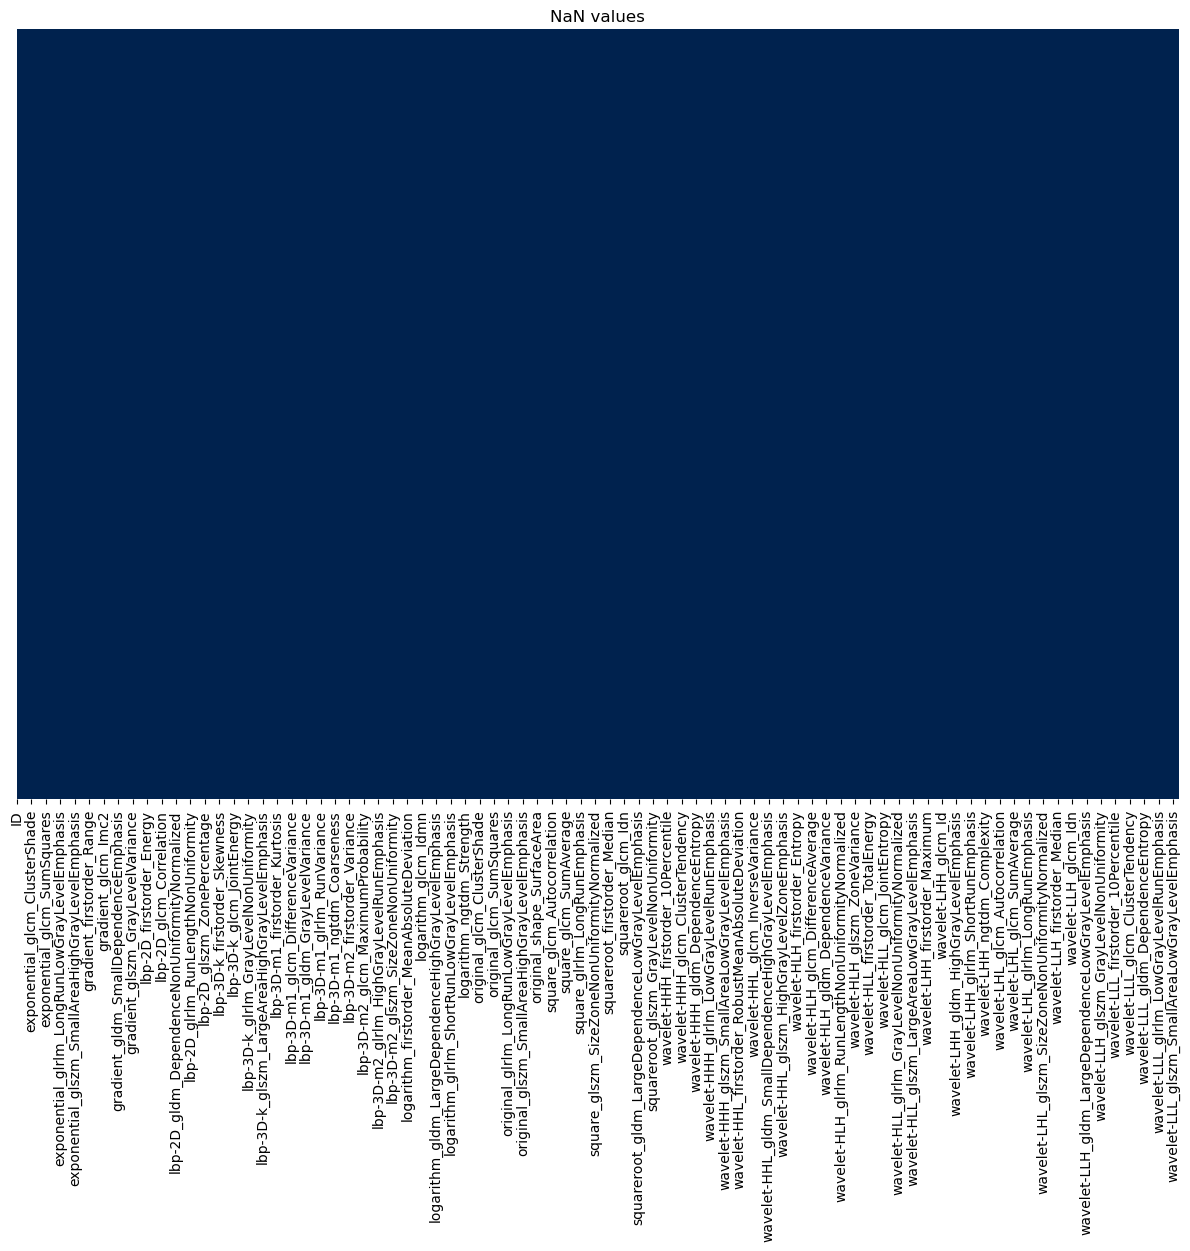

No NA values in the DataFrame.


In [49]:
#Eliminate index column
df_radiomic = df_radiomic.drop(df_radiomic.columns[0], axis=1)

## NAs count 
plt.figure(figsize=(15, 10))
sns.heatmap(df_radiomic.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_radiomic.isna().sum().sum() > 0:
    nan_percentage = (df_radiomic.isna().sum() / len(df_radiomic)) * 100
    df_radiomic_filtred = df_radiomic.loc[:, nan_percentage < 10]

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_radiomic_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()
else:
    df_radiomic_filtred = df_radiomic
    print("No NA values in the DataFrame.")

In [50]:
df_radiomic.shape

(141, 1689)

# Radiomic data exploratory analysis
## Radiomic data description table

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Merge radiomic data with clinical data, keeping only the 'ID' and 'RESPONSE' columns from the clinical data
merged_data = pd.merge(df_radiomic, df_clinical_filtred[['ID', 'RESPONSE']], on='ID')

# Specify the continuous variables (numerical columns)
continuous_vars = merged_data.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Filter out continuous variables with no variance
var = VarianceThreshold(threshold=0)  
continuous_vars_filtered = var.fit_transform(merged_data[continuous_vars]) 
continuous_vars_filtered = merged_data[continuous_vars].columns[var.get_support()]

# Check variables with identical groups
non_identical_vars = []
for var in continuous_vars_filtered:
    if len(merged_data[var].unique()) > 1:  
        non_identical_vars.append(var)

# Descriptive table
table = to(
    merged_data, 
    columns=continuous_vars,  
    continuous=continuous_vars,  
    groupby="RESPONSE",  
    nonnormal=non_identical_vars,  
    pval=True 
)

print(table.tabulate(tablefmt="fancy_grid"))

# Save the descriptive table to an Excel file
#table.to_excel('descriptive_comparative_radiomic_continuous_variables_with_nonnormal_pval.xlsx')

## Correltion matrix

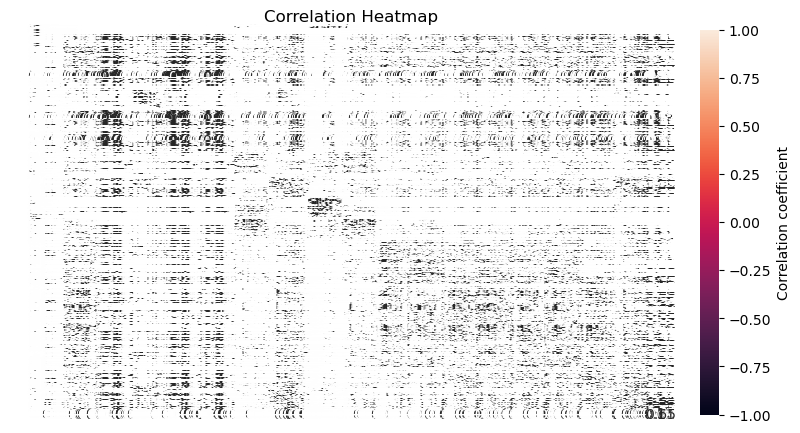

In [39]:
#Correlation matrix 
corr = df_radiomic.corr()

#Correlation matrix plot
plt.figure(figsize=(10, 5))
sns.heatmap(corr,
            xticklabels=False,
            yticklabels=False,
            cbar_kws={'label': 'Correlation coefficient'},
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

## Principal components 

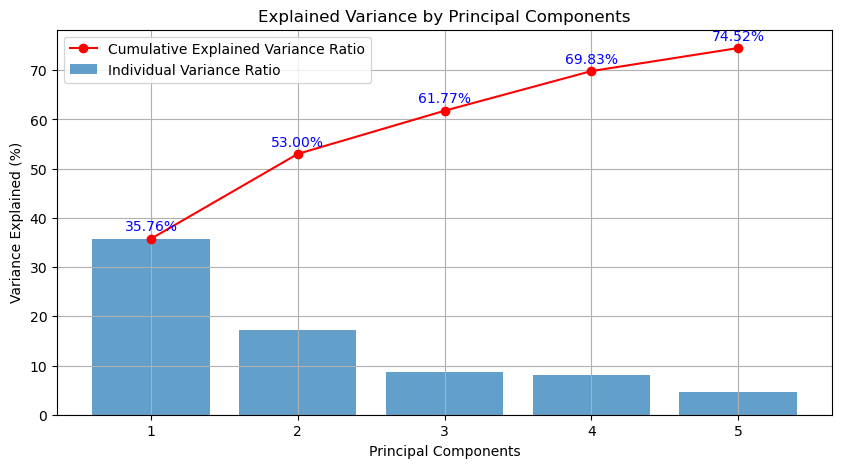

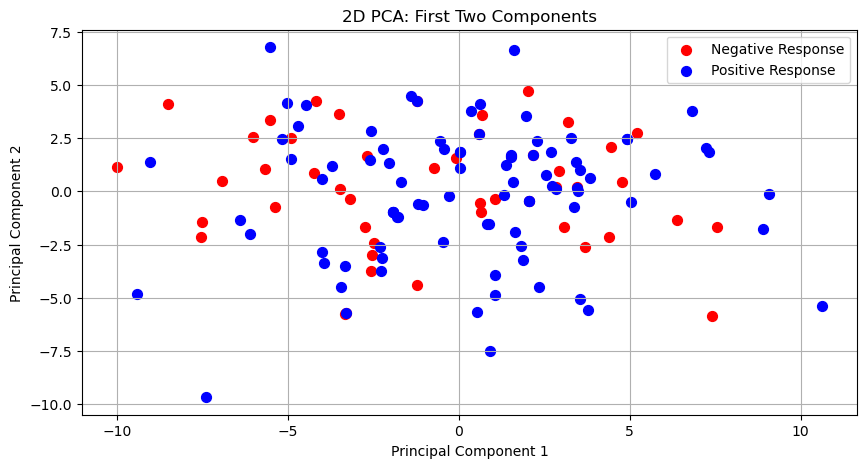

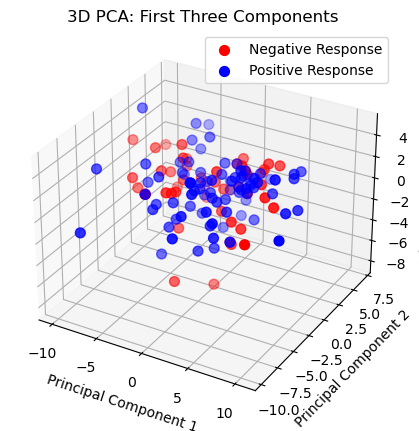

In [52]:
# Normalize the data
scaler = MinMaxScaler()
df_radiomic_scaled = scaler.fit_transform(df_radiomic)

# Apply PCA
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_radiomic_scaled)

# Calculate explained variance
individual_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(individual_variance) * 100

# Scree Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, 6), individual_variance * 100, alpha=0.7, align='center', label='Individual Variance Ratio')
ax.plot(range(1, 6), cumulative_explained_variance, marker='o', linestyle='-', color='r', label='Cumulative Explained Variance Ratio')

for i, percentage in enumerate(cumulative_explained_variance):
    ax.text(i + 1, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, color='blue')

ax.set_title('Explained Variance by Principal Components')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Variance Explained (%)')
ax.legend()
ax.grid(True)
plt.show()

# 2D Plot (PC1 vs PC2) with response type coloring
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['red', 'blue']  # Blue for negative, red for positive response
labels = ['Negative Response', 'Positive Response']

pca_fit_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_fit_df['response'] = df_clinical_filtred['RESPONSE']

for diag, color, label in zip([0, 1], colors, labels):
    indices = pca_fit_df['response'] == diag
    ax.scatter(pca_fit[indices, 0], pca_fit[indices, 1], c=color, s=50, label=label)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2D PCA: First Two Components')
ax.legend()
ax.grid(True)
plt.show()

# 3D Plot (PC1, PC2, PC3) with response type coloring
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

for diag, color, label in zip([0, 1], colors, labels):
    indices = pca_fit_df['response'] == diag
    ax.scatter(pca_fit[indices, 0], pca_fit[indices, 1], pca_fit[indices, 2], c=color, s=50, label=label)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA: First Three Components')
ax.legend()
plt.show()


## t-SNE analysis 

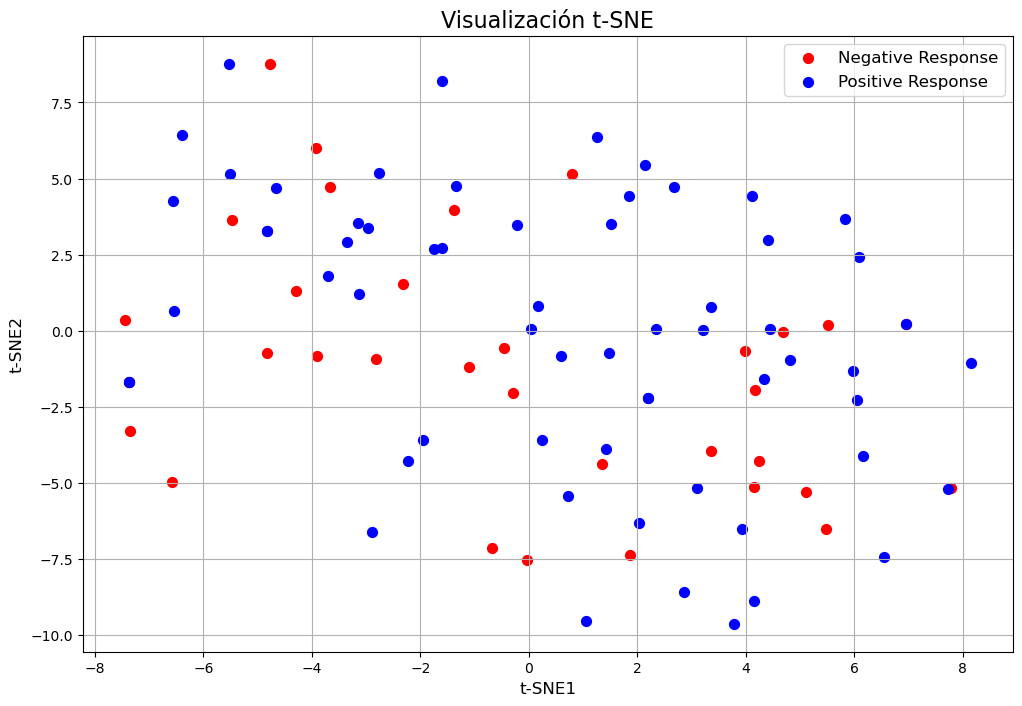

In [54]:
from sklearn.manifold import TSNE

# Reduce to 50 components before applying t-SNE
pca_reduction = PCA(n_components=50).fit_transform(df_radiomic_scaled)

# Apply t-SNE 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(pca_reduction)

# DataFrame with t_SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['response'] = y_train

# t-SNE Plot 
fig, ax = plt.subplots(figsize=(12, 8))
for diag, color, label in zip([0, 1], colors, labels):
    indices = tsne_df['response'] == diag
    ax.scatter(tsne_df.loc[indices, 't-SNE1'], 
               tsne_df.loc[indices, 't-SNE2'], 
               c=color, s=50, label=label)

ax.set_xlabel('t-SNE1', fontsize=12)
ax.set_ylabel('t-SNE2', fontsize=12)
ax.set_title('Visualización t-SNE', fontsize=16)
ax.legend(fontsize=12)
ax.grid()
plt.show()

# Radiomic data splitting

In [55]:
# Filter the radiomic data where 'ID' is in X_train
df_radiomic_train = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_train['ID'])]
df_radiomic_test = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_test['ID'])]

# New DataFrames  by removing the 'ID' column (features only)
df_radiomic_train_data = df_radiomic_filtred.drop(columns='ID')
df_radiomic_test_data = df_radiomic_filtred.drop(columns='ID')

# Radiomic data preprocessing (after data splitting)

In [ ]:
# Remove features with zero variance
var = VarianceThreshold(threshold=0)  
df_radiomic_train_data_filter = var.fit_transform(df_radiomic_train_data)

# Convert the resulting filtered data back into a DataFrame with the remaining feature names
df_radiomic_train_data_filter = pd.DataFrame(df_radiomic_train_data_filter, columns=df_radiomic_train_data.columns[var.get_support()])
print(f"Remaining features: {df_radiomic_train_data_filter.shape[1]}")

# Apply the same variance threshold transformation to the test data
df_radiomic_test_data_filter = var.transform(df_radiomic_test_data)
df_radiomic_test_data_filter = pd.DataFrame(df_radiomic_test_data_filter, columns=df_radiomic_test_data.columns[var.get_support()])

# Set the reduced training and testing data as X_train_reduced and X_test_reduced
X_train_reduced = df_radiomic_train_data_filter
X_test_reduced = df_radiomic_test_data_filter

print(f"Remaining features: {X_train_reduced.shape[1]}")
print(f"Remaining features: {X_test_reduced.shape[1]}")

# Clinical and radiomic data merging

In [57]:
# Resetting indexes
## Training set
df_radiomic_train = df_radiomic_train.reset_index(drop=True)
X_train_reduced = X_train_reduced.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_train_encoded = X_train_encoded.reset_index(drop=True)

## Testing set
df_radiomic_test = df_radiomic_test.reset_index(drop=True)
X_test_reduced = X_test_reduced.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)

# Concatenating IDs
## Training set
training_clinical = pd.concat([X_train[['ID']], X_train_encoded], axis=1)
training_radiomic = pd.concat([df_radiomic_train[['ID']], X_train_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
training_radiomic['ID'] = training_radiomic['ID'].astype(float)
training_clinical['ID'] = training_clinical['ID'].astype(float)

## Testing set
testing_clinical = pd.concat([X_test[['ID']], X_test_encoded], axis=1)
testing_radiomic = pd.concat([df_radiomic_test[['ID']], X_test_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)

# Df merging by ID
df_total_train = pd.merge(training_clinical, training_radiomic, on='ID', how='inner')
df_total_test = pd.merge(testing_clinical, testing_radiomic, on='ID', how='inner')
print(f'Merged dataset shape (train): {df_total_train.shape}')
print(f'Merged dataset shape (test): {df_total_test.shape}')

# Drop the "ID" column
df_total_train_data = df_total_train.drop(columns="ID")
df_total_test_data = df_total_test.drop(columns="ID")

# Check if the shapes are still correct after dropping "ID"
print(f"Training data shape (after dropping 'ID'): {df_total_train_data.shape}")
print(f"Testing data shape (after dropping 'ID'): {df_total_test_data.shape}")

# Make sure y is correctly set
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"Training set shape after scaling: {df_total_train_data.shape}")
print(f"Testing set shape after scaling: {df_total_test_data.shape}")

Merged dataset shape (train): (95, 1584)
Merged dataset shape (test): (42, 1584)
Training data shape (after dropping 'ID'): (95, 1583)
Testing data shape (after dropping 'ID'): (42, 1583)
Training set shape after scaling: (95, 1583)
Testing set shape after scaling: (42, 1583)


## Exploratory PCA before merged data preprocessing

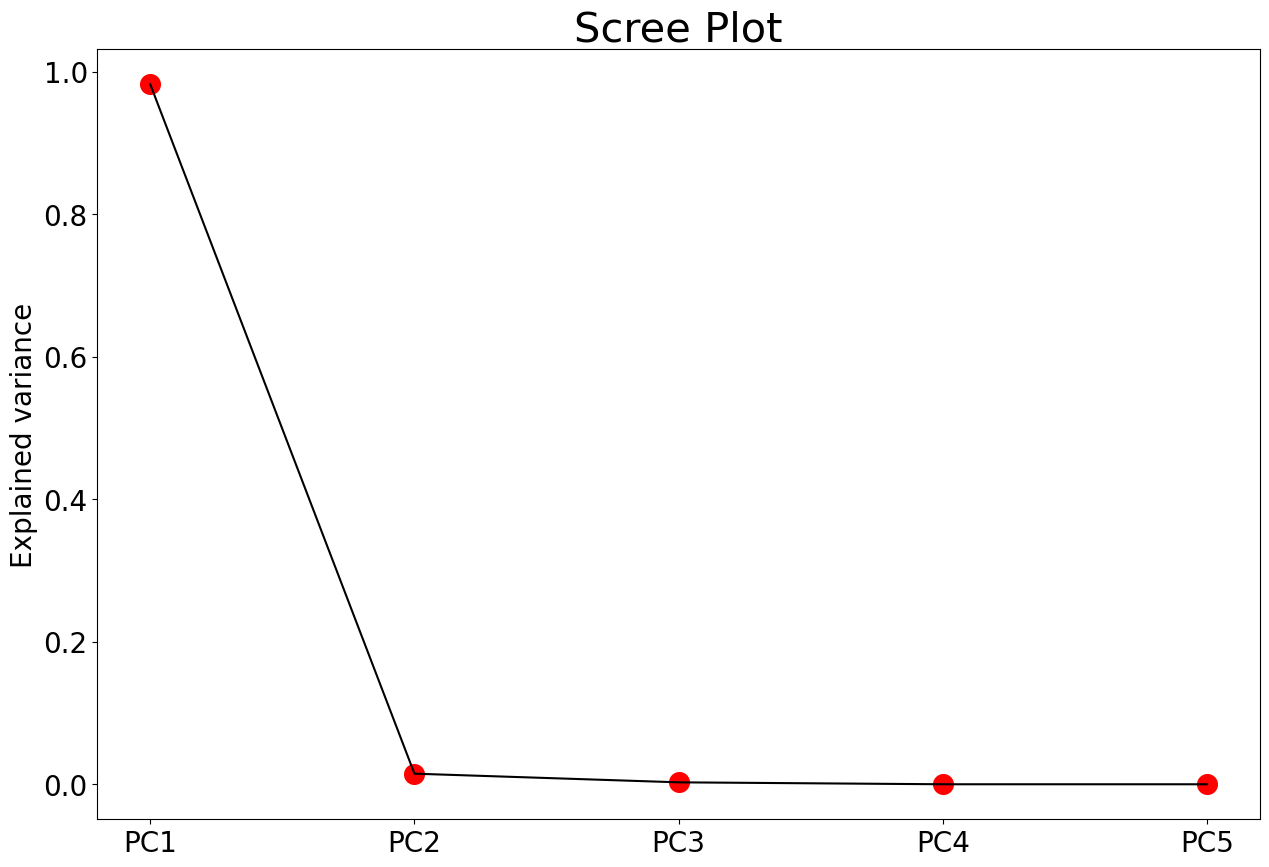

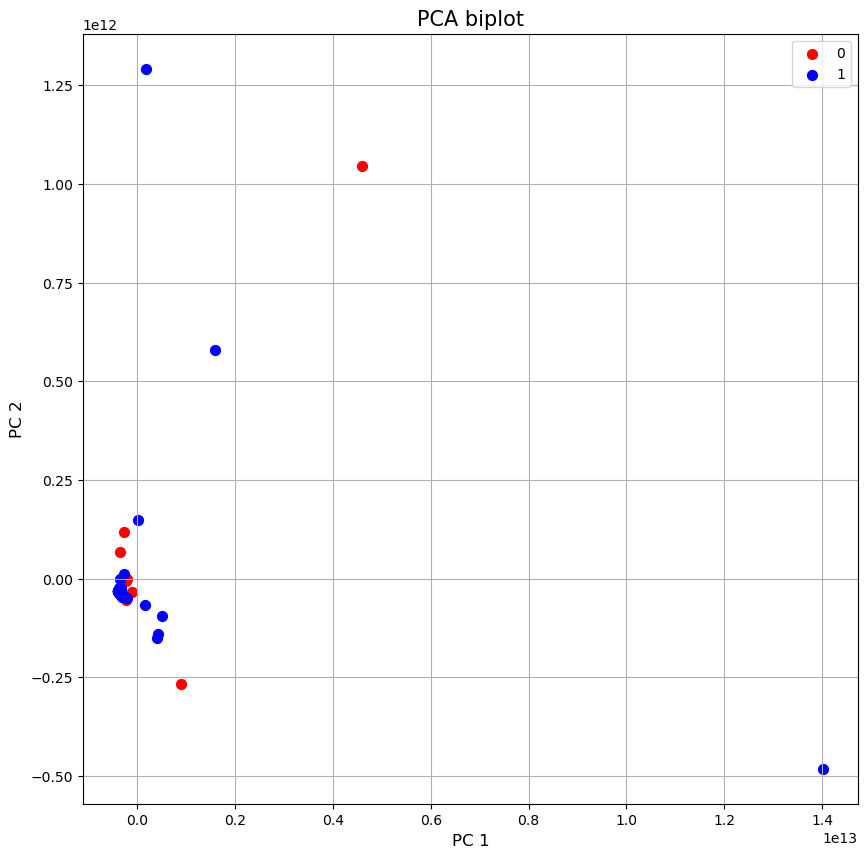

In [59]:
# Initialize PCA
pca = PCA(n_components=5)

# Fit PCA to the training data and transform the data into the new principal components
pca_fit = pca.fit_transform(df_total_train_data)

# Convert the PCA result into a DataFrame with column names for the principal components
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])

# Add the 'response' column to the PCA DataFrame, which contains the target variable values for the training set
pca_fit_df['response'] = y_train

# Plotting the explained variance ratio for each principal component
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

# PCA biplot visualization of the first two principal components
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

# Merged data preprocessing

In [60]:
# Defining categorical and numeric variables
categoric_variables = ['SEXO_Mujer', 'TABAQUISMO_No', 'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si', 'HTA_Si', 'DLP_Si', 'PATOLOGIA PULMONAR_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si', 'Tipo de lesion _PD pulmón ', 'Tipo de lesion _Primario sin antc', 'HISTOLOGIA_CEC', 'HISTOLOGIA_NoAP', 'HISTOLOGIA_Otros', 'LOCALIZACIÓN _LII', 'LOCALIZACIÓN _LMD', 'LOCALIZACIÓN _LSD', 'LOCALIZACIÓN _LSI']
numeric_variables = [col for col in df_total_train_data.columns if col not in categoric_variables]

# Numeric transformation pipeline
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0, 1)))])

# Full preprocessing pipeline 
preprocessing_pipeline = ColumnTransformer(
    transformers=[
       ('num', numeric_transformer, numeric_variables), 
       ('cat', 'passthrough', categoric_variables), 
    ]
)

# Preprocessing the training data
df_total_train_data_preprocessed = preprocessing_pipeline.fit_transform(df_total_train_data)
df_total_train_data_preprocessed = pd.DataFrame(df_total_train_data_preprocessed, columns=numeric_variables + categoric_variables)

# Preprocessing the test data
df_total_test_data_preprocessed = preprocessing_pipeline.transform(df_total_test_data)
df_total_test_data_preprocessed = pd.DataFrame(df_total_test_data_preprocessed, columns=numeric_variables + categoric_variables)

## Exploratory PCA for merged preprocessed data

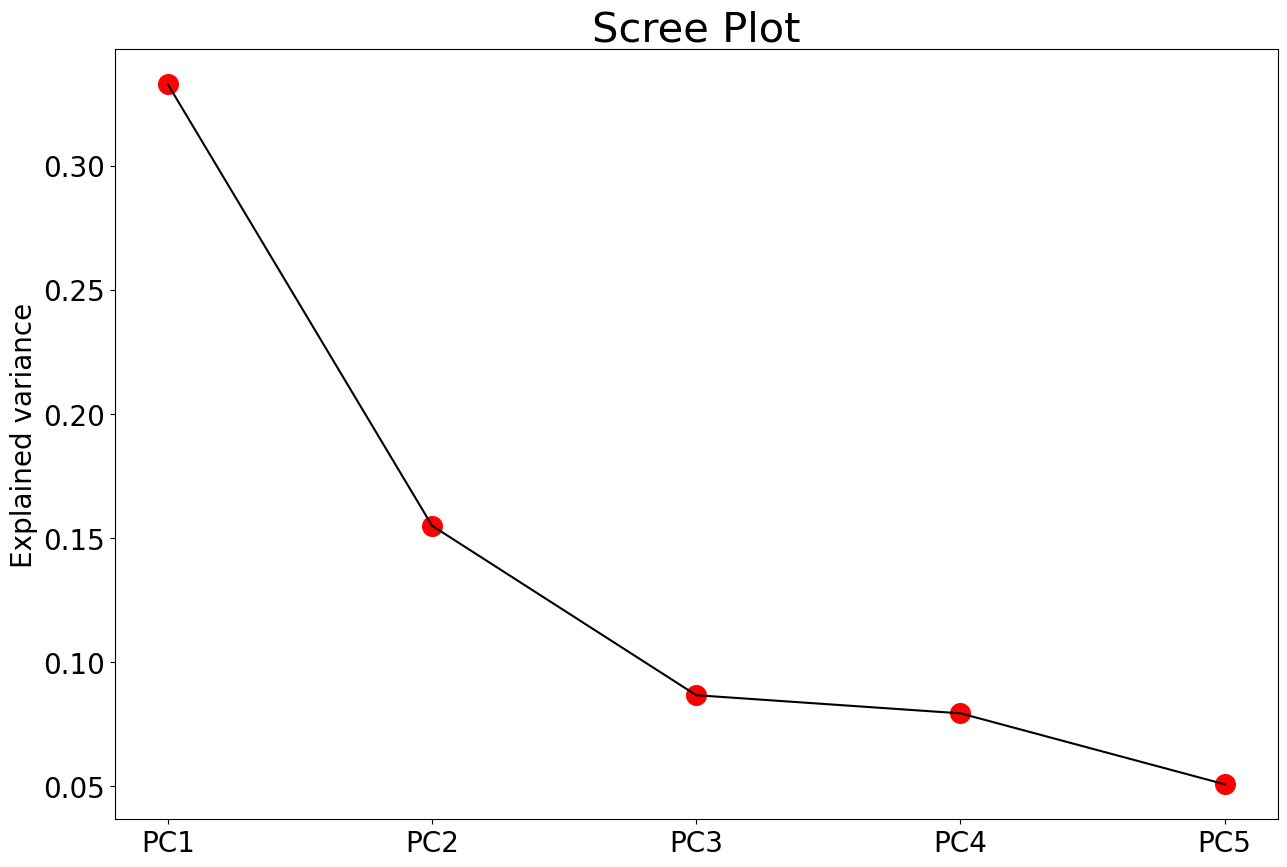

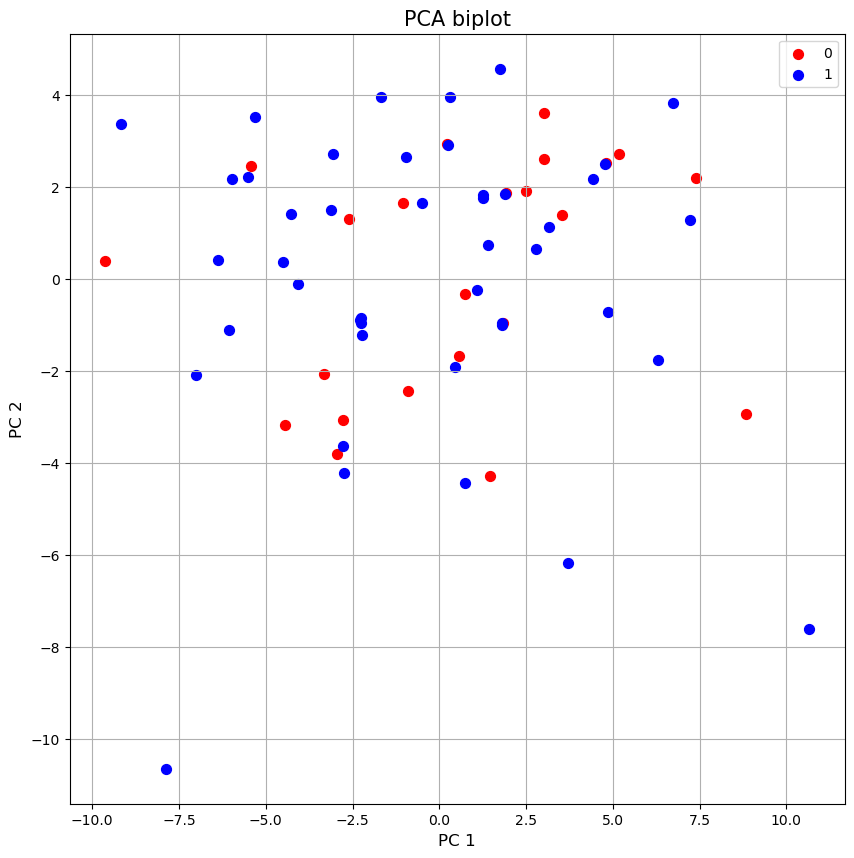

In [61]:
# Perform PCA with 5 principal components
pca = PCA(n_components=5)

# Apply PCA transformation to the preprocessed training data
pca_fit = pca.fit_transform(df_total_train_data_preprocessed)

# Create a DataFrame to hold the PCA results
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
# Add the response variable to the DataFrame (to be used for coloring in plots)
pca_fit_df['response'] = y_train

# Scree Plot:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

# PCA Biplot:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

## Preprocessed data save to a new dataframe

In [63]:
# Save the preprocessed training data to an Excel file
df_total_train_data_preprocessed.to_excel("Preprocessed_data_train_v4_30.70.xlsx")

# Save the preprocessed test data to an Excel file
df_total_test_data_preprocessed.to_excel("Preprocessed_data_test_v4_30.70.xlsx")

# Save the target values to an Excel file
y_train.to_excel("y_train_v4_30.70.xlsx")
y_test.to_excel("y_test_v4_30.70.xlsx")